# Detect chessboard

In [1]:
import glob, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from vidio.read import OpenCVReader
import multicam_calibration as mcc

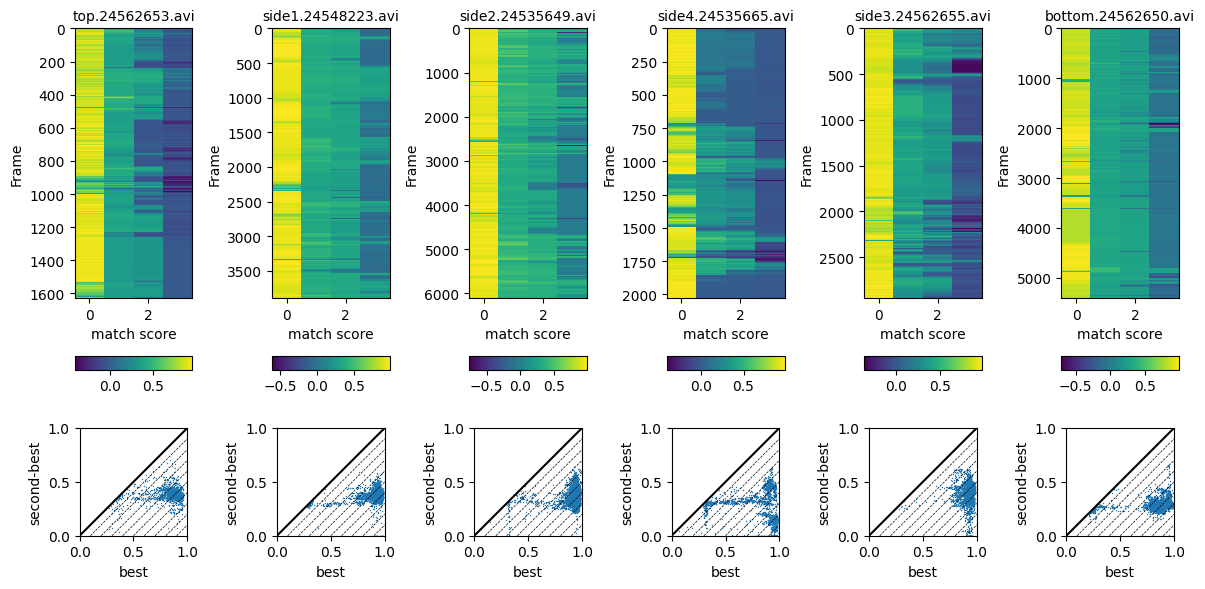

In [2]:
board_shape = (7,10)
square_size = 12.5

camera_names = ['top.24562653', 'side1.24548223', 'side2.24535649', 
                'side4.24535665', 'side3.24562655', 'bottom.24562650']

video_dir = '../../../../data/20230803_calibration'
video_paths = [f'{video_dir}/{camera}.avi' for camera in camera_names]

# detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths, mcc.detect_chessboard, n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5))

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
# for p in video_paths:
#     mcc.overlay_detections(p)


# Calibrate

## Initialization

In [8]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)

all_extrinsics, all_intrinsics, calib_poses = mcc.calibrate(
    all_calib_uvs, all_img_sizes, calib_objpoints, root=0, n_samples_for_intrinsics=100)


Estimating camera intrinsics


100%|█████████████████████████████████████| 6/6 [00:23<00:00,  3.89s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 6/6 [00:05<00:00,  1.01it/s]

Estimating camera extrinsics
Merging calibration object poses


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


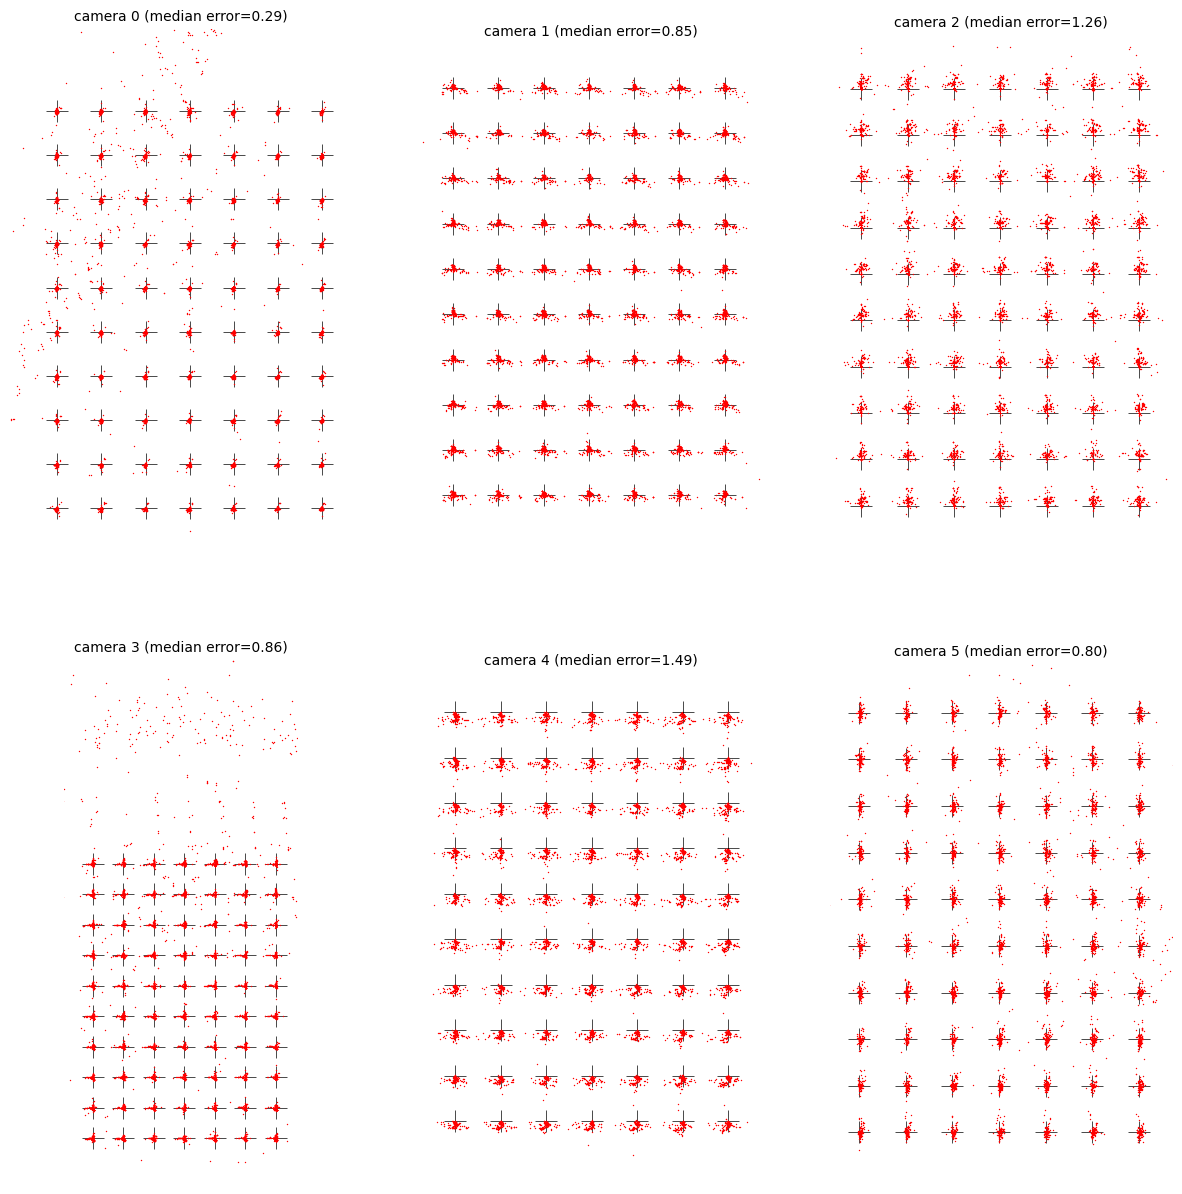

In [9]:
fig, mean_squared_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses)

## Bundle adjustment

In [10]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    mcc.bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=5000, ftol=1e-4)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2170e+06                                    5.53e+07    
       1              6         1.6100e+06      6.07e+05       7.85e+01       3.67e+07    
       2              7         1.4626e+06      1.47e+05       1.26e+02       1.97e+07    
       3              8         1.2094e+06      2.53e+05       3.34e+01       1.44e+07    
       4              9         9.9820e+05      2.11e+05       6.01e+01       1.01e+07    
       5             10         9.7245e+05      2.57e+04       7.25e+01       1.10e+07    
       6             11         9.0891e+05      6.35e+04       1.90e+01       1.03e+07    
       7             12         8.3628e+05      7.26e+04       4.06e+01       8.04e+06    
       8             13         8.1196e+05      2.43e+04       2.50e+01       8.43e+06    
       9             14         7.7420e+05      3.78e+04       2.62e+01       7.64e+06    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.76it/s]


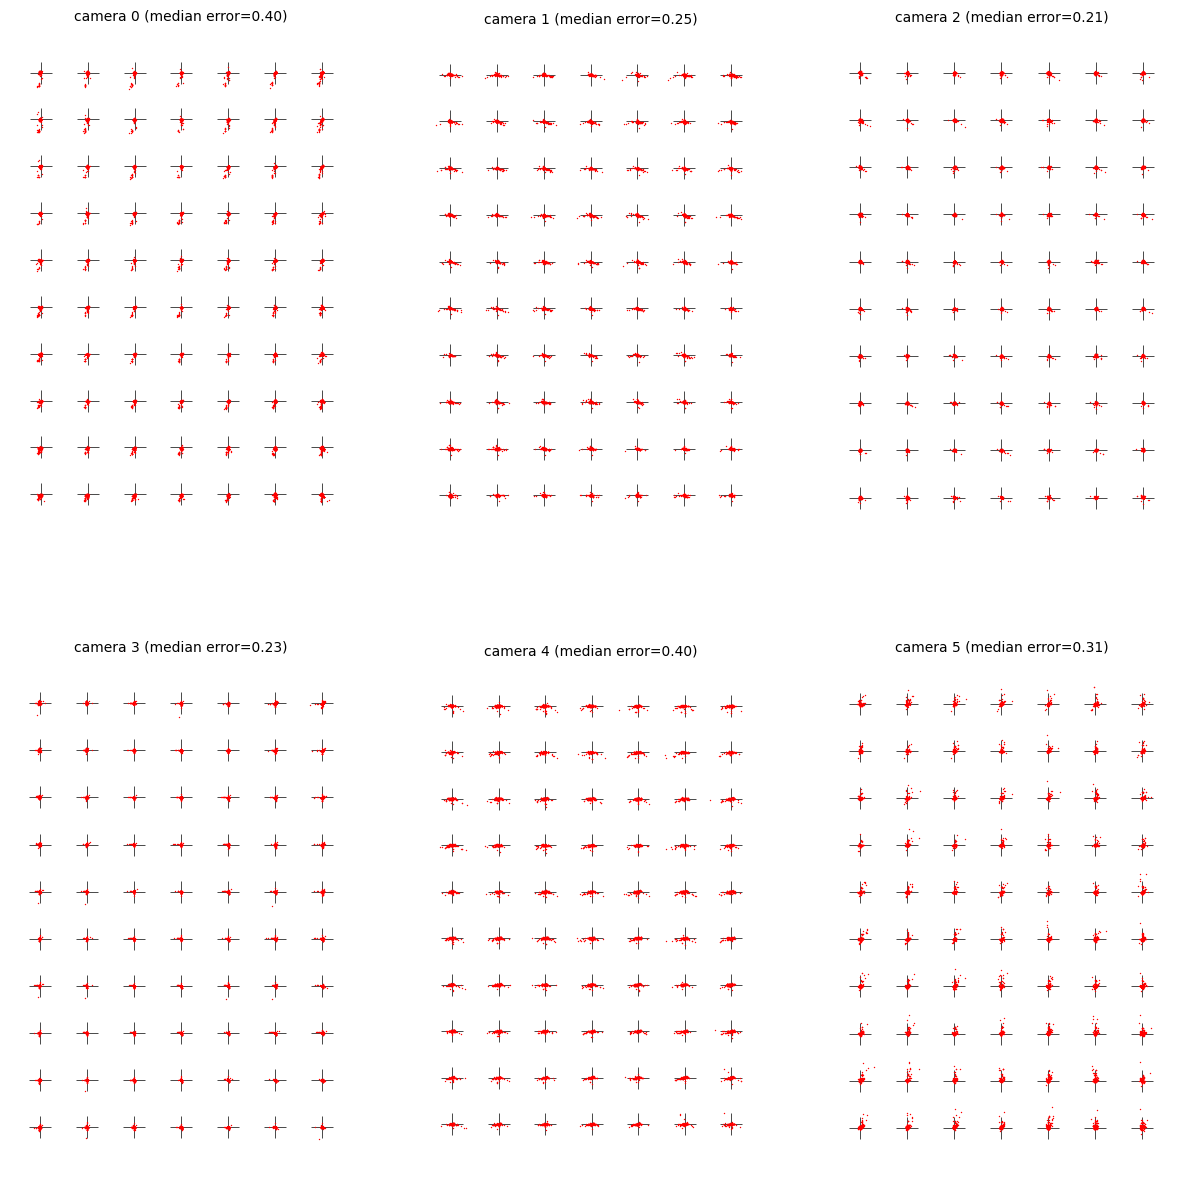

In [11]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses)

# Save results

In [13]:
# save for JARVIS
save_path = f'{video_dir}/CalibrationParameters/'
mcc.save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='jarvis')

# save for GIMBAL
save_path = f'{video_dir}/camera_params.h5'
mcc.save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='gimbal')